In [140]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pypfopt import EfficientFrontier, risk_models, expected_returns
from pypfopt import plotting  # For plotting efficient frontier

In [153]:
"""
start_date = '2022-06-01' # inclusive
end_date = '2024-09-20' # exclusive
"""

budget = 1000000  # Example total investment (you can change this value)


# Example data (replace with actual prices)
data = pd.read_csv("2year_closing.csv", parse_dates=True, index_col="Date")


# Calculate expected returns and sample covariance
mu = expected_returns.mean_historical_return(data)
# S = risk_models.sample_cov(data)
S = risk_models.CovarianceShrinkage(data).ledoit_wolf()

This classical model maximizes the Sharpe ratio of a portfolio of 48 stocks.

PyPfOpt calculates the Sharpe ratio as $$S_R = \frac{\mu - \text{Risk-free rate}}{\sigma} = \frac{\mu - 0.02}{\sigma}$$

However, do also note that PyPfOpt calcluates <b>log returns</b>. This means the each return is $r_{i+1} = \log \left(1 + \frac{p_{i+1} - p_{i}}{p_{i}} \right)$ and the mean historical return is $\left[ \Pi_{i=2}^n \left( 1 + r_{i+1} \right) \right]^{n} - 1$. The covariance matrix is made with log returns, <u>then multiplied by $n$.</u>

In [156]:
# Optimize for maximum Sharpe ratio




# Initialize Efficient Frontier
ef = EfficientFrontier(mu, S)

ef.add_constraint(lambda w: w <= 0.1)  # Limit weights to 10%
ef.add_constraint(lambda w: w >= 0.005)  # Limit weights to 10%

# ef.add_constraint(lambda w: )  # Limit weight to integer multiple of the stock


# Optimize the portfolio for maximum Sharpe ratio
weights = ef.max_sharpe()

# Convert the weights to a NumPy array
weights_array = np.array(list(weights.values()))
cleaned_weights = ef.clean_weights()
# print("Original cleaned weights:", cleaned_weights)

# Get the latest stock prices from your data
latest_prices = data.iloc[-1]

#Calculate the number of shares (rounded down to whole shares)
shares = np.floor(weights_array * budget / latest_prices)
# print("Number of shares for each stock:", shares)

# Recalculate the total value of the portfolio based on integer shares
total_value = np.dot(shares, latest_prices)

# Calculate the new weights based on the actual total portfolio value
new_weights = (shares * latest_prices) / total_value
# print("New weights based on integer shares:", new_weights)

# Step 7: Update the EfficientFrontier object with the new weights
ef.set_weights(dict(zip(data.columns, new_weights)))

# Optional: Clean the new weights for presentation
cleaned_weights = ef.clean_weights()
# print("Cleaned new weights:", cleaned_weights)

# # Adjust the total portfolio cost to ensure it's within budget
# total_cost = np.dot(shares, latest_prices)


In [187]:
# Portfolio performance
expected_return, volatility, sharpe_ratio = ef.portfolio_performance()
performance = ef.portfolio_performance(verbose=True)

Expected annual return: 39.3%
Annual volatility: 16.6%
Sharpe Ratio: 2.24


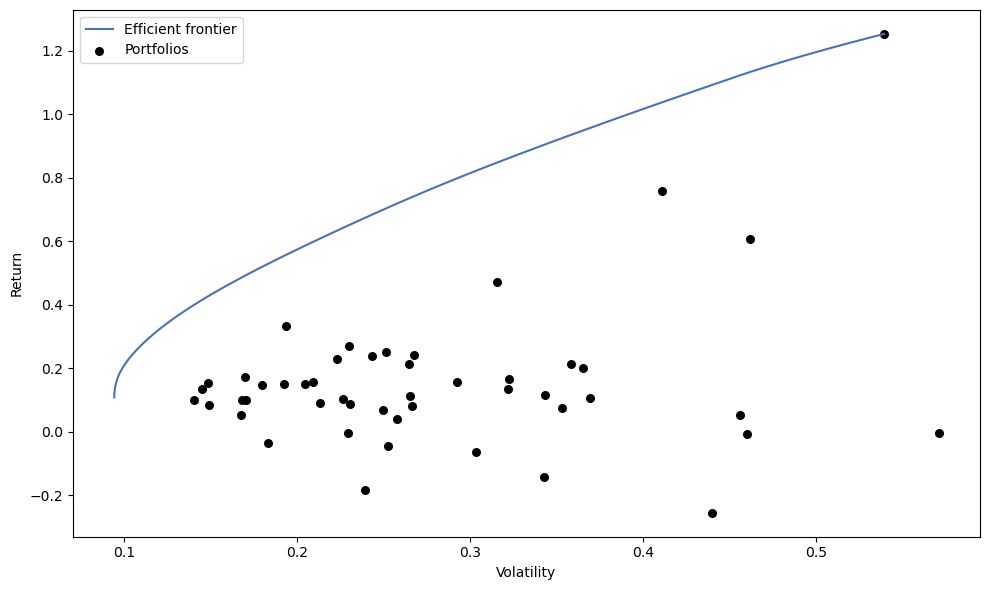

In [205]:
import matplotlib.pyplot as plt
from pypfopt import EfficientFrontier, plotting

# Create a new EfficientFrontier instance for plotting
ef_for_plotting = EfficientFrontier(mu, S)

# Plot Efficient Frontier (Risk vs Return) and show the black dots (assets)
fig, ax = plt.subplots(figsize=(10, 6))
plotting.plot_efficient_frontier(ef_for_plotting, ax=ax, show_assets=True)

handles, labels = ax.get_legend_handles_labels()
labels = [label.replace("assets", "Portfolios") for label in labels]

ax.legend(handles, labels)
plt.show()


In [219]:
print("Optimal number of shares of each stock:\n", shares, sep="")

total = round(sum(latest_prices * shares), 2)
print("\nTotal initial spending:", total, "dollars")
print("Expected portfolio value after 1 yr:", round(total * expected_return, 2), "dollars")

Optimal number of shares of each stock:
AAPL       21.0
MSFT       11.0
GOOGL      30.0
AMZN       26.0
TSLA       20.0
META       92.0
NFLX      141.0
NVDA      848.0
JPM       475.0
BAC       122.0
WMT      1281.0
PG        171.0
V          17.0
MA         10.0
DIS        53.0
PEP        28.0
KO         70.0
UNH        50.0
PFE       168.0
MRK       853.0
T         234.0
VZ        113.0
CSCO       97.0
INTC      236.0
ORCL      596.0
ADBE        9.0
CRM        18.0
BABA       56.0
XOM        43.0
CVX        34.0
GS          9.0
SPY         8.0
QQQ        10.0
IWM        22.0
DIA        11.0
TLT        50.0
GLD       418.0
SLV       177.0
XLF       109.0
XLK        22.0
XLE        56.0
XLV        32.0
ARKK      105.0
GDX       125.0
BA         32.0
NKE        61.0
MCD        17.0
SBUX       51.0
Name: 2024-09-19 00:00:00-04:00, dtype: float64

Total initial spending: 994796.84 dollars
Expected portfolio value after 1 yr: 1246327.28 dollars


Given weights $w_1 + \dots + w_n = 100 \%$, where $w_i = \frac{V_i}{V_p}$ is the $i$th asset's value as a fraction of the the portfolio's value:
- the portfolio's expected rate of return is the weighted average $k_p = \sum^n_{i=1} w_i k_{ei}$
- the portfolio's risk is the standard deviation $\sqrt{\sum^n_{i=1} \sum^n_{j=1} w_i w_j \text{Cov}_{ij}}$. (As you might imagine, the variation can also be a measure of risk.)

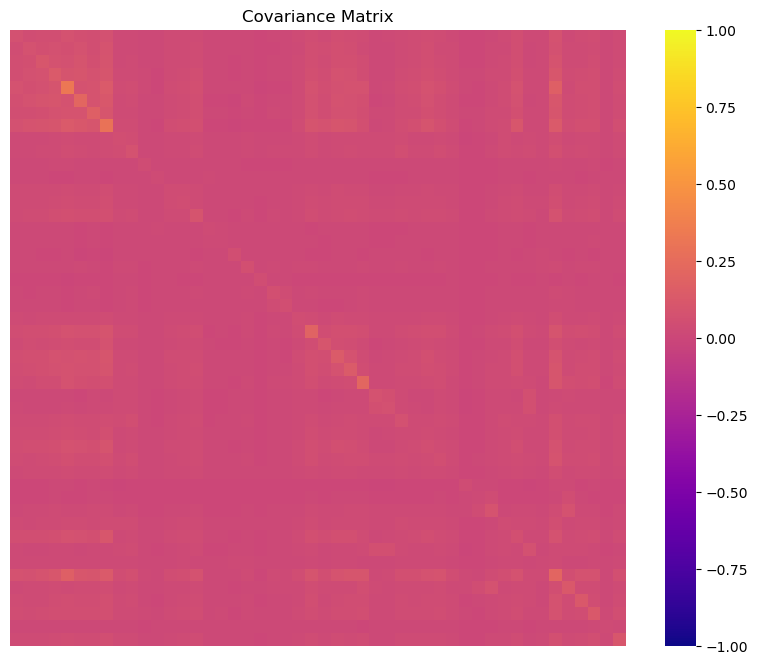

In [165]:
# Plot covariance matrix as a heatmap without stock labels
plt.figure(figsize=(10, 8))
sns.heatmap(S, annot=False, cmap="plasma", cbar=True, square=True,
            vmin=-1, vmax=1, xticklabels=False, yticklabels=False)
plt.title("Covariance Matrix")
plt.show()